# Проект: Определение возраста покупателей

___
**Описание проекта**  

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.
___
**Цель**  

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.
___
**Инструкция по выполнению проекта**

1. Проведите исследовательский анализ набора фотографий.
2. Подготовьте данные к обучению.
3. Обучите нейронную сеть и рассчитайте её качество.
___
**Описание данных:**  

Данные взяты с сайта `ChaLearn Looking at People` (http://chalearnlap.cvc.uab.es/dataset/26/description/). Они находятся в папке `/datasets/faces/`.  

В вашем распоряжении одна папка со всеми изображениями (`/final_files`) и CSV-файл `labels.csv` с двумя колонками: `file_name` и `real_age`.   

Извлечь данные из папки вам поможет новый метод `ImageDataGenerator` — `flow_from_dataframe(dataframe, directory, ...)`.

<h1>Содержание<span class="tocSkip"></span></h1><br>
<div class="toc">
    <ul class="toc-item">
        <li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1.&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li>
        <li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2.&nbsp;&nbsp;</span>Обучение модели</a></span></li>
        <li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-3"><span class="toc-item-num">3.&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li>
        <li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-4"><span class="toc-item-num">4.&nbsp;&nbsp;</span>Общий вывод</a></span></li>
        <li><span><a href="#Чек-лист" data-toc-modified-id="Чек-лист-5"><span class="toc-item-num">5.&nbsp;&nbsp;</span>Чек-лист</a></span></li>
    </ul>
</div>

## Исследовательский анализ данных

### Импортируем необходимые библиотеки. Считаем данные из csv-файла в датафрейм и сохраним в переменную `labels`. Путь к файлу:

`/datasets/faces/labels.csv`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from scipy import stats as st

In [2]:
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
try:
    labels = pd.read_csv('/datasets/faces/labels.csv')
except:
    print('File_not_found')

### Изучим общую информацию о полученном датафрейме

**Добавим настройки для удобства отображения данных**

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.options.display.float_format = '{:,.2f}'.format

#Если необходимо вернуть дефолтные настройки, раскомментируй строку ниже
#pd.reset_option('all')

**Выведем первые 10 строчек датафрейма `labels` на экран.**

In [5]:
labels.head(10)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


**Колонка `file_name` содержит название файла, `real_age` реальный возраст человека.**

**Посмотрим на размер данных (количество строк, колонок).**

In [6]:
print(f'\nКоличество строк: {labels.shape[0]}\nКоличество колонок: {labels.shape[1]}\n')


Количество строк: 7591
Количество колонок: 2



**Просмотрим статистическую сводку каждой колонки, чтобы узнать распределение данных в каждой колонки. Используем метод `describe()`.**

In [7]:
labels.describe(include = "all")

,file_name,real_age
count,7591,"7,591.00"
unique,7591,NaN
top,004932.jpg,NaN
freq,1,NaN
mean,NaN,31.20
std,NaN,17.15
min,NaN,1.00
25%,NaN,20.00
50%,NaN,29.00
75%,NaN,41.00


**Выведем основную информацию о датафрейме с помощью метода `info()`.**

In [8]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


**Размер выборки составляет 7591 фото.**

**Проверим дубликаты.**

In [9]:
labels.duplicated().sum()

0

**Выведем гистограмму распределения возраста.**

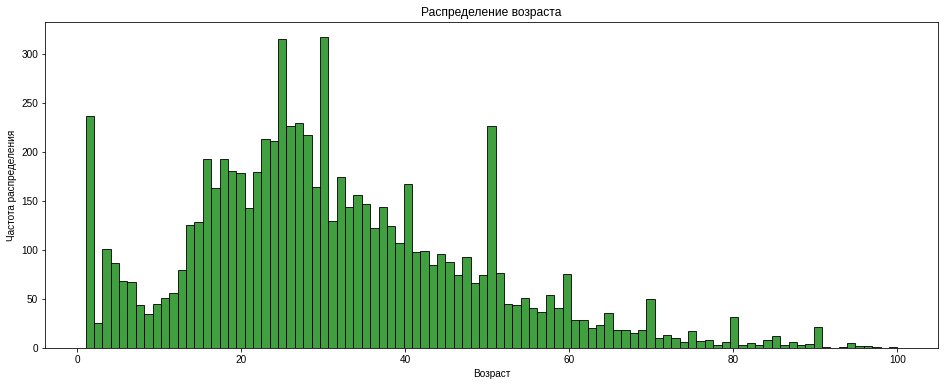

In [10]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.histplot(labels['real_age'],
             bins=len(labels['real_age'].unique()),
             color='g')
ax.set_title('Распределение возраста')
plt.style.use('seaborn-white')
plt.xlabel('Возраст')
plt.ylabel('Частота распределения')
plt.show()

**Распределение данных относительно нормальное, со смещением влево. Видим пики данных возле круглых дат (25, 30, 40, 50, 60 лет). Возможно человек, который размечал данные, не знал конкретного возраста респондентов.**

**Выведем "Boxplot" распределения возраста.**

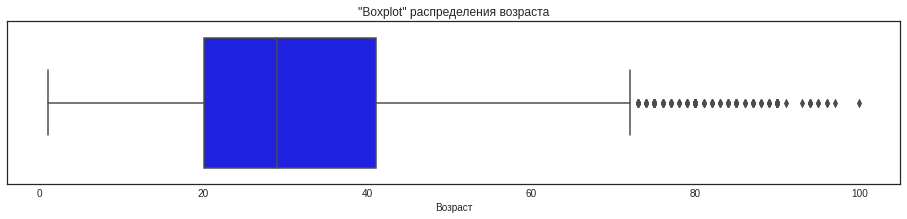

In [11]:
plt.figure(figsize=(16, 3))
sns.boxplot(x=labels['real_age'],
            color='b')                        
plt.title(label='"Boxplot" распределения возраста')
plt.xlabel('Возраст')
plt.show()

**Медиана ~ 29 лет, левый и правый квантиль - 20 и 41 соответственно. Правый ус - 72 года.**

**Отобразим первое изображение из выборки.**

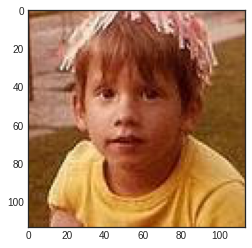

In [12]:
image = Image.open('/datasets/faces/final_files/' + labels.loc[0, 'file_name'])
array = np.array(image)
plt.imshow(array);

**Отобразим на экране 10–15 фотографий и посмотрим, как устроен датасет. Извлечь данные из папки вам поможет метод `ImageDataGenerator`**

In [13]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


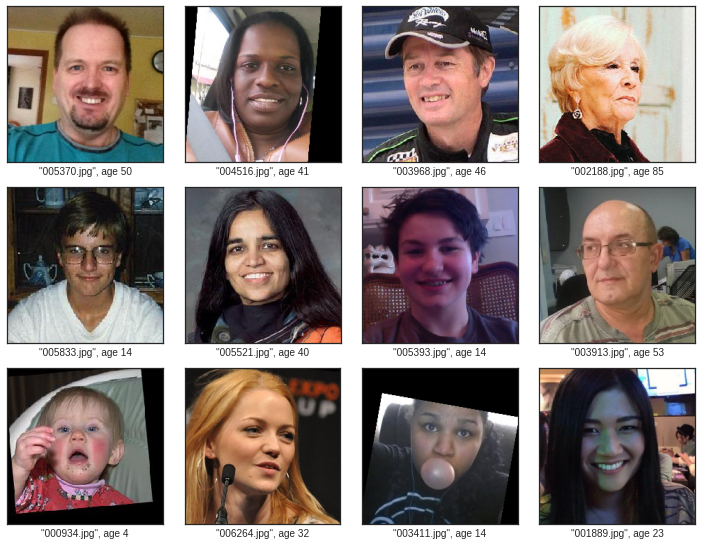

In [14]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xlabel (f'"{train_gen_flow.filenames[train_gen_flow.index_array[i]]}", age {train_gen_flow[0][1][i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Выводы:**

> **Не все фото сделаны четко и в профиль. Имеются фото с прикрытыми лицами, в очках, черно-белые фото, а также фото перевернутые относительно центра.**  

> **По графикам можем определить, что выборка имеет относительно нормальное распределение со смещением влево. Медиана - 29 лет, а правый ус - 72 года. Это говорит о том, что модель будет обучаться на неравномерно распределенной выборке.**

## Обучение модели

### Подготовим код и далее обучим модель в GPU-тренажёре.

**Задача:**  

Постройте и обучите свёрточную нейронную сеть на датасете с фотографиями людей. Добейтесь значения MAE на тестовой выборке не больше 8.
Функцию загрузки тестовой выборки `load_test(path)` напишите самостоятельно. Вместе со старыми функциями в коде должны быть:

* `load_train(path),`
* `load_test(path),`
* `create_model(input_shape),`
* `train_model(model, train_data, test_data, batch_size, epochs, steps_per_epoch, validation_steps).`

**Код для тренажера:**

In [ ]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       rescale=1.0 / 255,
                                       horizontal_flip=True,
                                       # vertical_flip=True,
                                       rotation_range=30
                                       # width_shift_range=0.2,
                                       # height_shift_range=0.2
                                       )

    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                           directory=path + 'final_files/',
                                                           x_col='file_name',
                                                           y_col='real_age',
                                                           target_size=(224, 224),
                                                           batch_size=32,
                                                           class_mode='raw',
                                                           subset='training',
                                                           seed=12345)

    return train_datagen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1.0 / 255)

    test_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                          directory=path + 'final_files/',
                                                          x_col='file_name',
                                                          y_col='real_age',
                                                          target_size=(224, 224),
                                                          batch_size=32,
                                                          class_mode='raw',
                                                          subset='validation',
                                                          seed=12345)

    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        include_top=False,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(150, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='relu'))
    
    optimizer = Adam(lr=0.0001)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model 

**Логи:**

In [ ]:
Train for 178 steps, validate for 60 steps

Epoch 1/5

2023-05-19 16:16:00.063398: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2023-05-19 16:16:00.666108: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

178/178 - 109s - loss: 296.3265 - mae: 12.5397 - val_loss: 515.9681 - val_mae: 17.6430

Epoch 2/5

178/178 - 101s - loss: 92.9020 - mae: 7.3793 - val_loss: 657.0174 - val_mae: 20.5153

Epoch 3/5

178/178 - 101s - loss: 67.7383 - mae: 6.2698 - val_loss: 305.3149 - val_mae: 12.8495

Epoch 4/5

178/178 - 99s - loss: 52.3324 - mae: 5.5520 - val_loss: 295.4003 - val_mae: 13.2389

Epoch 5/5

178/178 - 99s - loss: 44.6763 - mae: 5.1511 - val_loss: 96.0083 - val_mae: 7.4315

WARNING:tensorflow:sample_weight modes were coerced from

  ...

    to  

  ['...']

60/60 - 10s - loss: 96.0083 - mae: 7.4315

Test MAE: 7.4315

**Получили метрику качества МАЕ - `7.4315`. Модель в среднем ошибается на это значение при прогнозе возраста.**

## Анализ обученной модели

* **Обученная свёрточная нейронная сеть `ResNet50` показала метрику качества `7.4315`, что довольно неплохой результат для 5 эпох (В статье о датасете, с которым работали, значение MAE равно `5.4`).**
* **За 5 эпох обучения для тренировочной выборки удалось уменьшить MAE с `12.53` до `5.15`. Дальнейшее обучение возможно улучшит результат.**

## Общий вывод

**`Анализ данных для обучения показал:`**  

**1. Не все фото сделаны четко и в профиль. Имеются фото с прикрытыми лицами, в очках, черно-белые фото, а также фото перевернутые относительно центра.**  

**2. По графикам можем определить, что выборка имеет относительно нормальное распределение со смещением влево. Медиана - 29 лет, а правый ус - 72 года. Это говорит о том, что модель будет обучаться на неравномерно распределенной выборке.**

**`Анализ обученной модели показал:`**  

**Для решения задачи, была обучена свёрточная нейронная сеть `ResNet50`, которая по фотографии определяет приблизительный возрас человека. Нейронная сеть решает задачу регресии, т.к. необходимо предсказать количество лет.**  

* **Нейронная сеть ошибается в среднем на `7.4315` года при прогнозе возраста по фото. Это дает возможность:**
    1. Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
    2. Контролировать добросовестность кассиров при продаже алкоголя.

**Обученная свёрточная нейронная сеть `ResNet50` соответствует поставленной задаче сетевого супермаркета «Хлеб-Соль» и может внедриться, как система компьютерного зрения для обработки фотографий покупателей.**

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы